## 연합뉴스 타이틀 주제 분류
* 데이터셋 출처 : 
    * [뉴스 토픽 분류 AI 경진대회 - DACON](https://dacon.io/competitions/official/235747/overview/description)

## 기초 분류 모델 만들기

* 데이터 로드
* 데이터 전처리
* 단어 벡터화(BOW, TF-IDF)
* 분류기 설정하기
* 분류기로 학습시키기
* 학습의 정확도 보기
* 테스트 데이터 예측하기
* 실제 데이터와 예측결과의 차이를 보기

<img src="https://i.imgur.com/Sxm12BY.png" width="900">



## 라이브러리 로드

In [2]:
# 데이터 분석을 위한 pandas, 수치계산을 위한 numpy, 시각화를 위한 seaborn, matplotlib 을 로드합니다.
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## 시각화를 위한 폰트 설정

In [3]:
def get_font_family():
    """
    시스템 환경에 따른 기본 폰트명을 반환하는 함수
    """
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        # Linux(colab)
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family


# style 설정은 꼭 폰트설정 위에서 합니다.
# style 에 폰트 설정이 들어있으면 한글폰트가 초기화 되어 한글이 깨집니다.
plt.style.use("seaborn")
# 폰트설정
plt.rc("font", family=get_font_family())

# 마이너스폰트 설정
plt.rc("axes", unicode_minus=False)

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

<AxesSubplot:title={'center':'한글'}>

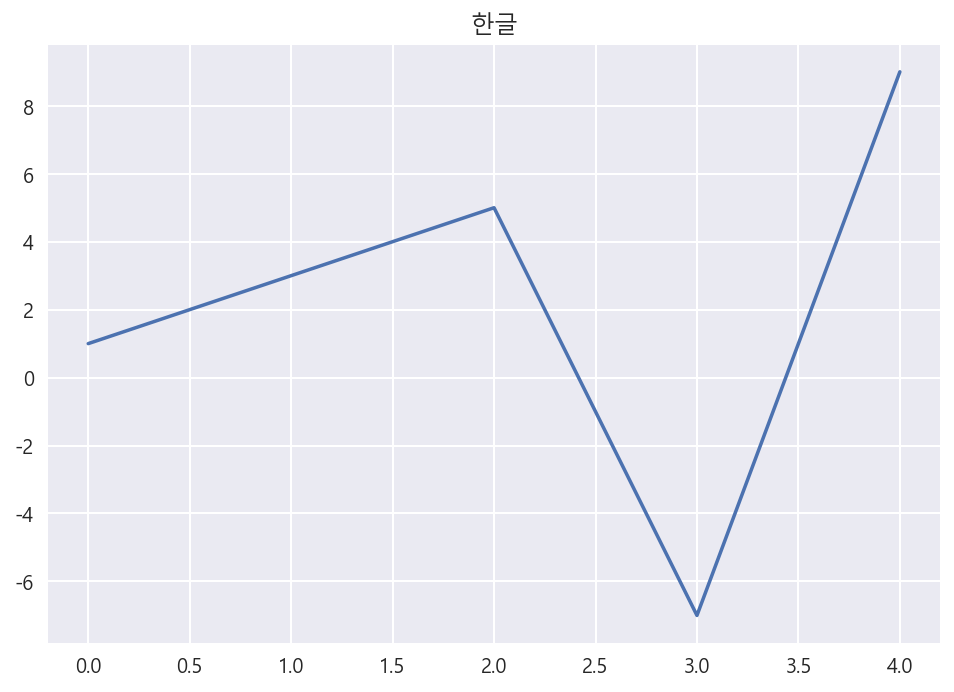

In [4]:
pd.Series([1, 3, 5, -7, 9]).plot(title="한글")

## 데이터 로드

In [5]:
# 학습, 예측 데이터셋을 불러옵니다.
# train, test
train = pd.read_csv("data/train_data.csv")
test = pd.read_csv("data/test_data.csv")
train.shape , test.shape

((45654, 3), (9131, 2))

In [6]:
# 토픽을 불러옵니다.
# topic
topic = pd.read_csv("data/topic_dict.csv")
topic

,topic,topic_idx
0,IT과학,0
1,경제,1
2,사회,2
3,생활문화,3
4,세계,4
5,스포츠,5
6,정치,6


## 6 문자 전처리
### 6.1 전처리 함수로 전처리 하기

* [정규 표현식 - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/%EC%A0%95%EA%B7%9C_%ED%91%9C%ED%98%84%EC%8B%9D)


In [7]:
# 정규표현식 불러오기
import re

def preprocessing(text):
    # 개행문자 제거
    text = re.sub('\\\\n', ' ', text)
    # 특수문자 제거
    # 특수문자나 이모티콘 등은 때로는 의미를 갖기도 하지만 여기에서는 제거했습니다.
    # text = re.sub('[?.,;:|\)*~`’!^\-_+<>@\#$%&-=#}※]', '', text)
    # 한글, 영문, 숫자만 남기고 모두 제거하도록 합니다.
    # text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]', ' ', text)
    # 한글, 영문만 남기고 모두 제거하도록 합니다.
    text = re.sub('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z]', ' ', text)
    # 중복으로 생성된 공백값( +는 중복이 여러 개라는 뜻)을 제거합니다.
    text = re.sub('[\s]+', ' ', text)
    # 영문자를 소문자로 만듭니다.
    text = text.lower()
    return text

In [8]:
# 정규표현식 확인
text = "전처리가 잘~~~되는지 확인 합니다. 공    백도 확인하고 숫자0-9도 확인 합니다. EnglisH는 모두 소문자로 만듭니다."
preprocessing(text)

'전처리가 잘 되는지 확인 합니다 공 백도 확인하고 숫자 도 확인 합니다 english는 모두 소문자로 만듭니다 '

In [9]:
# map을 통해 전처리 일괄 적용
train['title'] = train['title'].map(preprocessing)
test['title'] = test['title'].map(preprocessing)

In [10]:
train

,index,title,topic_idx
0,0,인천 핀란드 항공기 결항 휴가철 여행객 분통,4
1,1,실리콘밸리 넘어서겠다 구글 조원 들여 전역 거점화,4
2,2,이란 외무 긴장완화 해결책은 미국이 경제전쟁 멈추는 것,4
3,3,nyt 클린턴 측근 기업 특수관계 조명 공과 사 맞물려종합,4
4,4,시진핑 트럼프에 중미 무역협상 조속 타결 희망,4
...,...,...,...
45649,45649,kb금융 미국 ib 스티펠과 제휴 선진국 시장 공략,1
45650,45650,보 서울시교육청 신종코로나 확산에 개학 연기 휴업 검토,2
45651,45651,게시판 키움증권 키움 영웅전 실전투자대회,1
45652,45652,답변하는 배기동 국립중앙박물관장,2


### 6.2 불용어 제거

In [11]:
# 불용어 제거
# 불용어를 추가하여 어휘를 추가로 제거할 수 있습니다.
def remove_stopwords(text):
    tokens = text.split(' ')
    stops = [ '합니다', '하는', '할', '하고', '한다', 
             '그리고', '입니다', '그', '등', '이런', '및','제', '더']
    meaningful_words = [w for w in tokens if not w in stops]
    return ' '.join(meaningful_words)

In [12]:
# map을 통해 불용어 일괄 제거
train['title'] = train['title'].map(remove_stopwords)
test['title'] = test['title'].map(remove_stopwords)

## 7 학습 예측 데이터셋

In [13]:
# 학습, 예측 데이터셋 정의
# 학습세트(예: 시험의 기출문제)
# 예측세트(예: 실전 시험문제)
# X_train_text 
# X_test_text

X_train_text = train['title'] # 시험의 기출문제 
X_test_text = test['title'] # 실전 시험문제 
X_train_text.shape , X_test_text.shape

((45654,), (9131,))

In [14]:
# 정답값으로 사용할 topic_idx 를 변수에 담아 재사용 합니다.
# label_name
label_name = "topic_idx"

In [15]:
# 학습 세트의 정답 == 기출문제의 정답 
# y_train
y_train = train["topic_idx"]
print(y_train.shape)
y_train.head()

(45654,)


0    4
1    4
2    4
3    4
4    4
Name: topic_idx, dtype: int64

## 8 벡터화
* 머신러닝이나 딥러닝 알고리즘은 문자를 이해할 수 없습니다. 내부에서는 수치 계산이 이루어지기 때문에 문자를 숫자로 변경해 주어야 합니다.


### 8.1 CountVectorizer
* CountVectorizer 는 사이킷런에서 제공하는 bag of words 를 만들 수 있는 방법입니다.
* 텍스트 문서 모음을 토큰 수의 행렬로 변환합니다.

* 단어들의 카운트(출현 빈도)로 여러 문서들을 벡터화
* 문서목록에서 각 문서의 feature(문장의 특징) 노출수를 가중치로 설정한 BOW 벡터를 생성
* 카운트 행렬, 단어 문서 행렬 (Term-Document Matrix, TDM))
* max_df, min_df 인수를 사용하여 문서에서 토큰이 나타난 횟수를 기준으로 단어장을 구성할 수도 있음 
* 토큰의 빈도가 max_df로 지정한 값을 초과 하거나 min_df로 지정한 값보다 작은 경우에는 무시하며 인자 값은 정수인 경우 횟수, 부동소수점인 경우 비율을 의미
* API documentation:https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

### 8.2 사용법
1. 문서를 토큰 리스트로 변환한다.
2. 각 문서에서 토큰의 출현 빈도를 센다.
3. 각 문서를 BOW 인코딩 벡터로 변환한다.
4. 매개 변수
    * analyzer : 단어, 문자 단위의 벡터화 방법 정의
    * ngram_range : BOW 단위 수 (1, 3) 이라면 1개~3개까지 토큰을 묶어서 벡터화
    * max_df : 어휘를 작성할 때 문서 빈도가 주어진 임계값보다 높은 용어(말뭉치 관련 불용어)는 제외 (기본값=1.0)
        * max_df = 0.90 : 문서의 90% 이상에 나타나는 단어 제외
        * max_df = 10 : 10개 이상의 문서에 나타나는 단어 제외
    * min_df : 어휘를 작성할 때 문서 빈도가 주어진 임계값보다 낮은 용어는 제외합니다. 컷오프라고도 합니다.(기본값=1.0)
        * min_df = 0.01 : 문서의 1% 미만으로 나타나는 단어 제외
        * min_df = 10 : 문서에 10개 미만으로 나타나는 단어 제외
    * stop_words : 불용어 정의

In [16]:
# CountVectorizer 로 벡터화 합니다.
# cvect
from sklearn.feature_extraction.text import CountVectorizer

cvect = CountVectorizer()
cvect.fit(X_train_text) # 학습 

CountVectorizer()

In [17]:
# 변환 (train 기준으로 학습한 후, train과 test를 변환해주는 것)
# X_train, X_test
X_train = cvect.transform(X_train_text)
X_test = cvect.transform(X_test_text)
X_train.shape , X_test.shape

((45654, 77961), (9131, 77961))

In [18]:
# 단어 사전
# feature_names
feature_names = cvect.get_feature_names()
feature_names

['aa',
 'aa로',
 'abba',
 'abba룰',
 'abl글로벌자산운용',
 'abs',
 'abu',
 'abu상',
 'abu서',
 'ab운용',
 'ac',
 'ace',
 'acl',
 'acl행',
 'acm',
 'activex',
 'ac밀란',
 'ad',
 'adt캡스',
 'afa',
 'afc',
 'afc챔스',
 'afc챔피언스리그',
 'afc컵',
 'afd',
 'afp',
 'ag',
 'ag결과',
 'ag까지',
 'ag는',
 'ag대표팀',
 'ag승선',
 'ag엔트리',
 'ag여자축구',
 'ag축구',
 'ag축구대표팀',
 'ag행',
 'ah',
 'ai',
 'aia생명',
 'aiib',
 'ai가',
 'ai개발자',
 'ai검색',
 'ai기능',
 'ai기반',
 'ai기술',
 'ai기술로',
 'ai기업',
 'ai는',
 'ai대화',
 'ai대회',
 'ai데이터',
 'ai도움으로',
 'ai등',
 'ai로',
 'ai로봇이',
 'ai리서치센터',
 'ai만',
 'ai면접',
 'ai보다',
 'ai보안',
 'ai분야',
 'ai비서',
 'ai사업',
 'ai상담원',
 'ai서비스',
 'ai서비스로',
 'ai센터장',
 'ai스피커',
 'ai시대',
 'ai시장',
 'ai에',
 'ai연구소',
 'ai와',
 'ai월드컵',
 'ai융합에',
 'ai의',
 'ai인재양성',
 'ai정책연구소로',
 'ai조직도',
 'ai집적단지',
 'ai추천',
 'ai칩',
 'ai특허',
 'ai플랫폼',
 'ai협동로봇',
 'aj렌터카',
 'al',
 'alcs',
 'alcs서',
 'alds',
 'all',
 'amg',
 'anc',
 'anc의',
 'ap',
 'apbc',
 'apec',
 'api',
 'api스퀘어',
 'api포털',
 'apoel전',
 'apt',
 'aptld',
 'ap우주항공과',
 'ap위성통신',
 'ap통신',
 '

In [19]:
# np.sum 으로 위에서 구한 train_feature_vector 의 값을 모두 더합니다. axis=0 으로 합니다. 
vocab_sum = np.sum(X_train.toarray(), axis = 0)
vocab_sum

array([2, 2, 1, ..., 3, 1, 1], dtype=int64)

In [20]:
# 위에서 구한 빈도수를 그래프로 그립니다.
series_vocab_sum = pd.Series(vocab_sum)
series_vocab_sum.index = feature_names
df_vocab_sum = series_vocab_sum.to_frame().T
df_vocab_sum

,aa,aa로,abba,abba룰,abl글로벌자산운용,abs,abu,abu상,abu서,ab운용,...,힘을,힘의,힘이,힘입어,힘주는,힘찬,힘합쳐,힙합,힙합공연장,힙합까지
0,2,2,1,1,1,3,1,1,1,2,...,2,1,3,4,1,5,1,3,1,1


<AxesSubplot:>

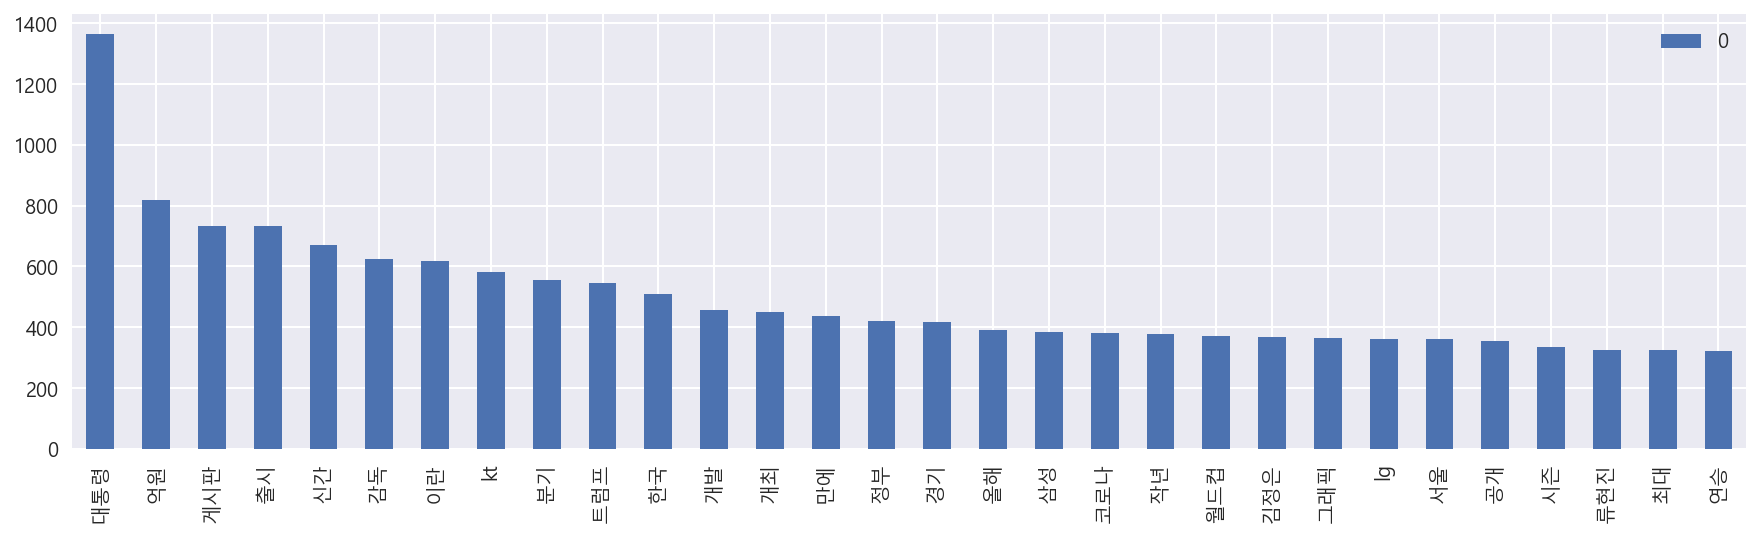

In [21]:
df_vocab_sum.T.sort_values(by=0, ascending=False).head(30).plot.bar(figsize = (15,4))

## 9 모델 불러오기

In [25]:
# DecisionTreeClassifier 를 불러옵니다.
# model
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(max_depth=10)

## 10 학습

In [26]:
# fit 으로 학습시킵니다.
model.fit(X_train , y_train)

DecisionTreeClassifier(max_depth=10)

## 11 트리 알고리즘 분석하기
* 의사결정나무를 시각화 합니다.

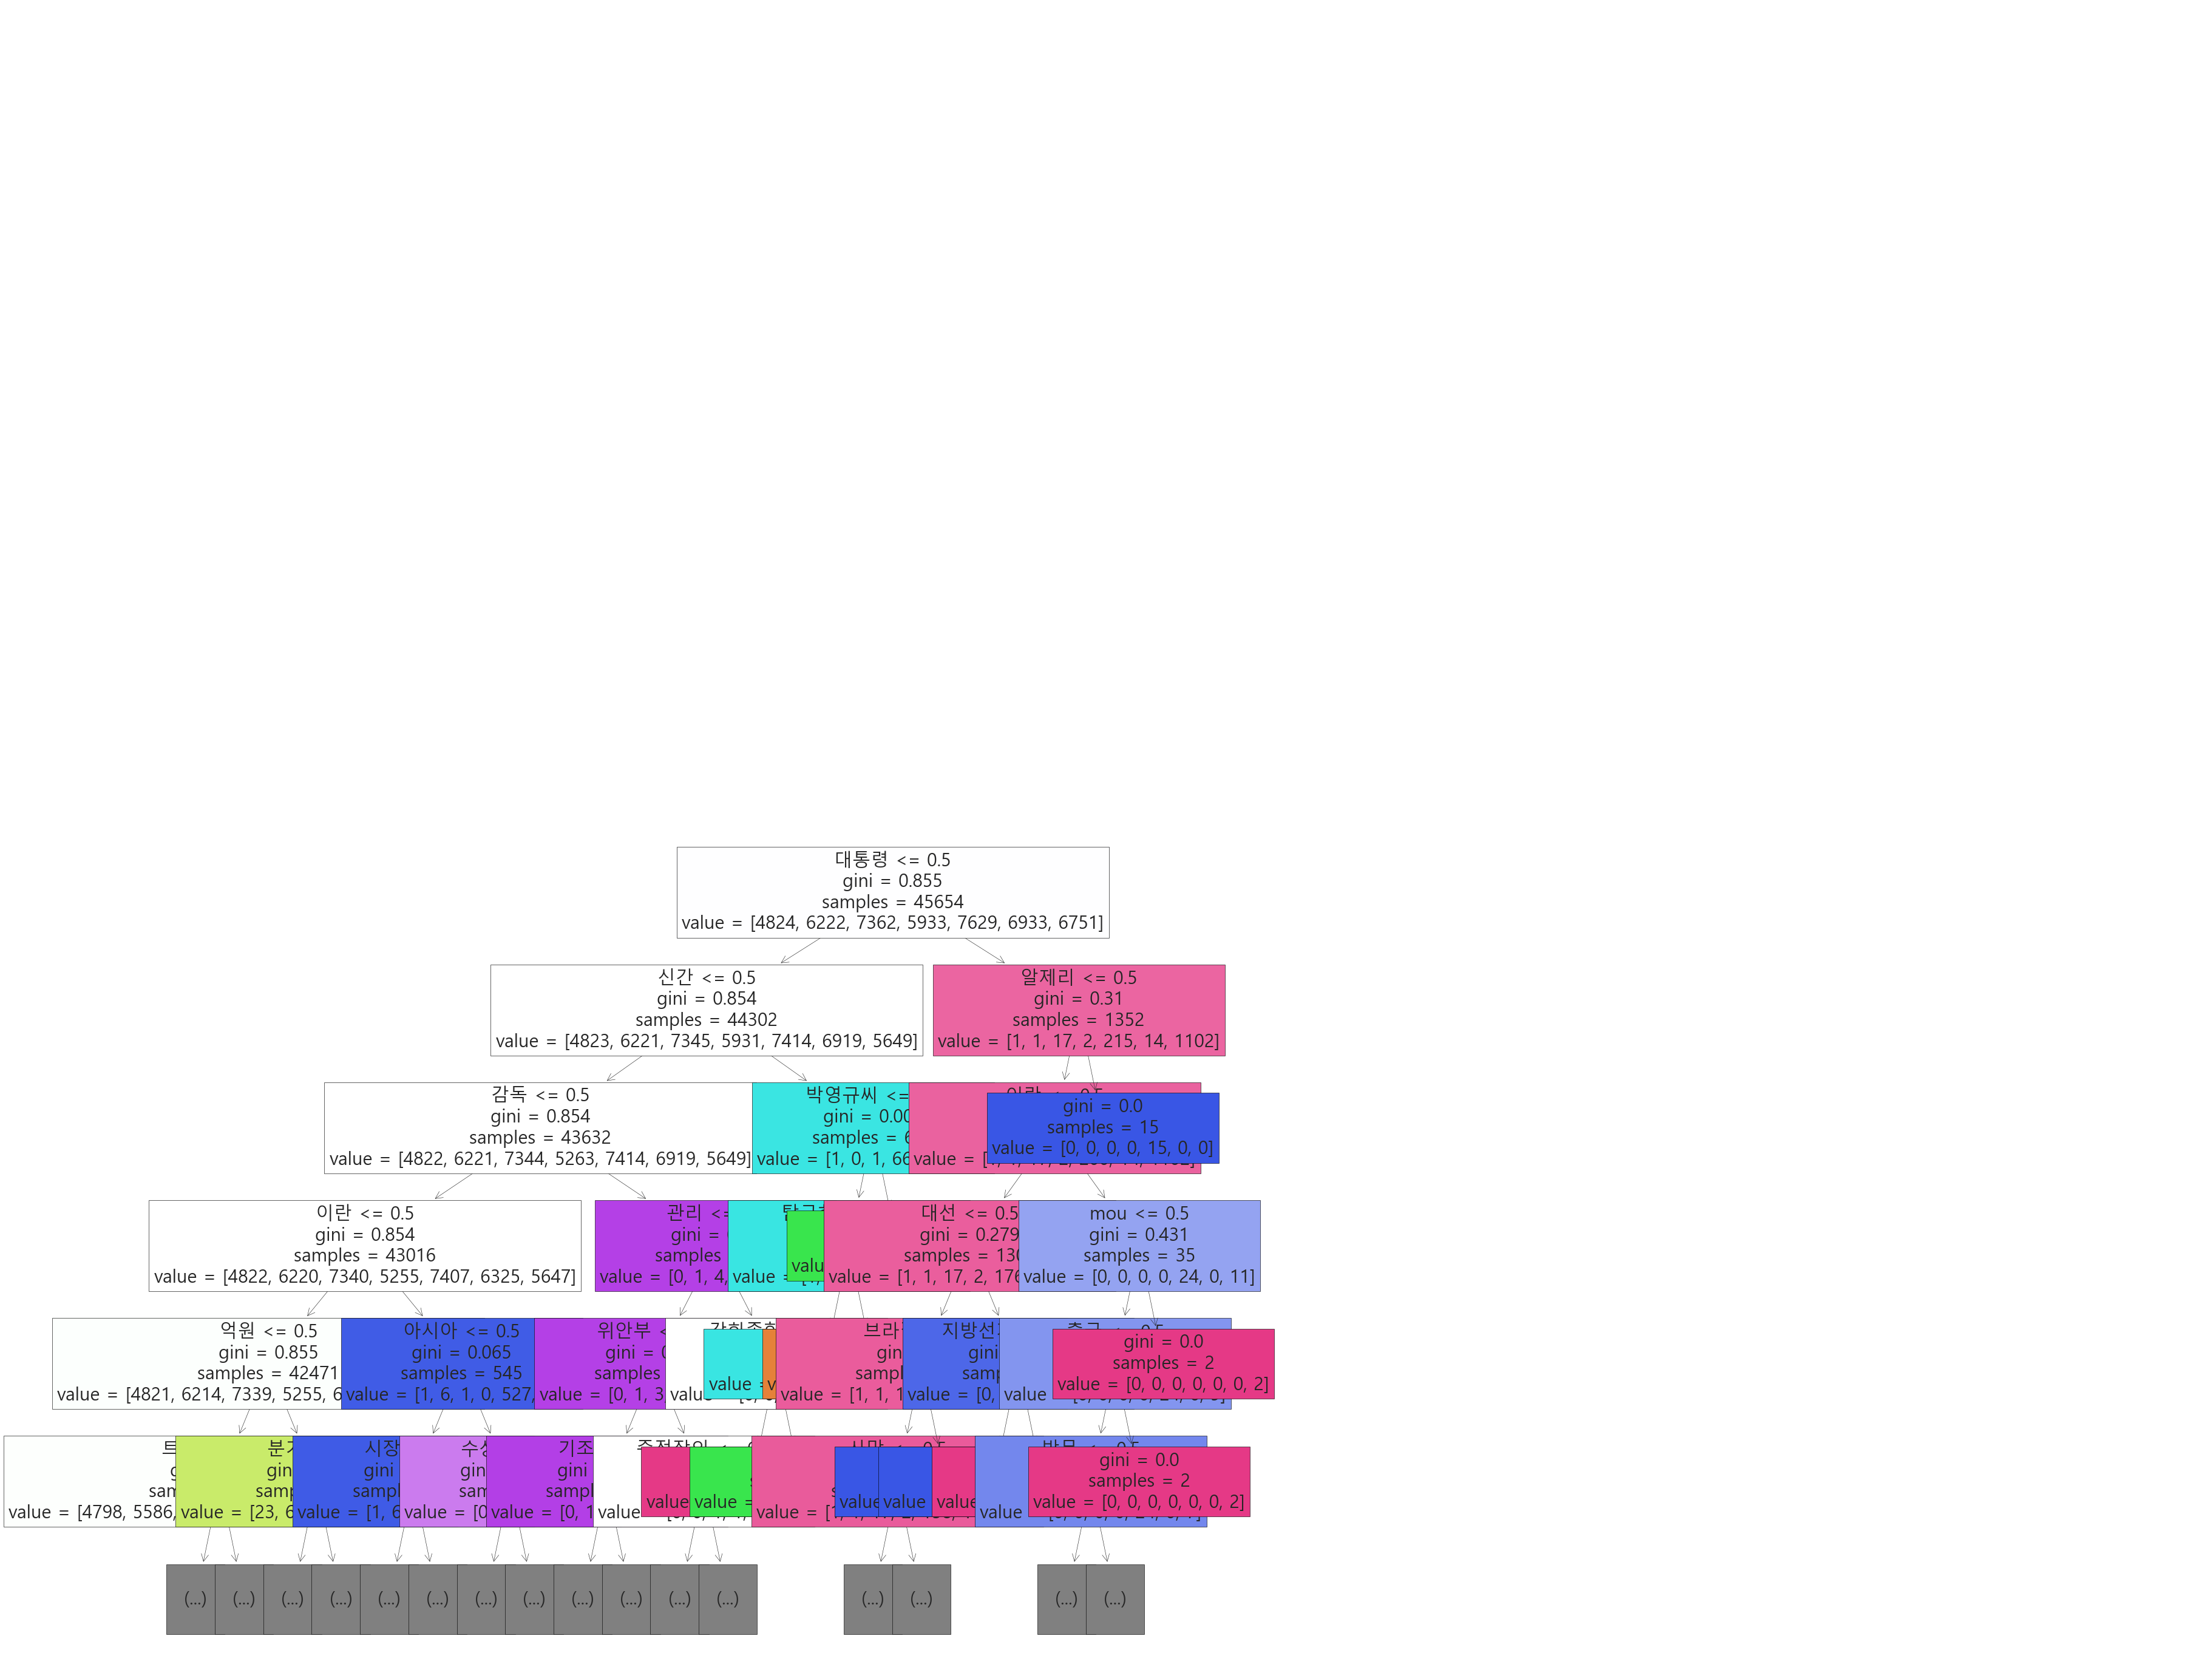

In [32]:
# plot_tree 로 시각화 합니다.
from sklearn.tree import plot_tree
plt.figure(figsize=(30,25))
plot_tree(model, max_depth = 5,
          feature_names = feature_names, 
          filled = True,
          fontsize=15)
plt.show()

In [26]:
feature_names

['aa',
 'aa로',
 'abba',
 'abba룰',
 'abl글로벌자산운용',
 'abs',
 'abu',
 'abu상',
 'abu서',
 'ab운용',
 'ac',
 'ace',
 'acl',
 'acl행',
 'acm',
 'activex',
 'ac밀란',
 'ad',
 'adt캡스',
 'afa',
 'afc',
 'afc챔스',
 'afc챔피언스리그',
 'afc컵',
 'afd',
 'afp',
 'ag',
 'ag결과',
 'ag까지',
 'ag는',
 'ag대표팀',
 'ag승선',
 'ag엔트리',
 'ag여자축구',
 'ag축구',
 'ag축구대표팀',
 'ag행',
 'ah',
 'ai',
 'aia생명',
 'aiib',
 'ai가',
 'ai개발자',
 'ai검색',
 'ai기능',
 'ai기반',
 'ai기술',
 'ai기술로',
 'ai기업',
 'ai는',
 'ai대화',
 'ai대회',
 'ai데이터',
 'ai도움으로',
 'ai등',
 'ai로',
 'ai로봇이',
 'ai리서치센터',
 'ai만',
 'ai면접',
 'ai보다',
 'ai보안',
 'ai분야',
 'ai비서',
 'ai사업',
 'ai상담원',
 'ai서비스',
 'ai서비스로',
 'ai센터장',
 'ai스피커',
 'ai시대',
 'ai시장',
 'ai에',
 'ai연구소',
 'ai와',
 'ai월드컵',
 'ai융합에',
 'ai의',
 'ai인재양성',
 'ai정책연구소로',
 'ai조직도',
 'ai집적단지',
 'ai추천',
 'ai칩',
 'ai특허',
 'ai플랫폼',
 'ai협동로봇',
 'aj렌터카',
 'al',
 'alcs',
 'alcs서',
 'alds',
 'all',
 'amg',
 'anc',
 'anc의',
 'ap',
 'apbc',
 'apec',
 'api',
 'api스퀘어',
 'api포털',
 'apoel전',
 'apt',
 'aptld',
 'ap우주항공과',
 'ap위성통신',
 'ap통신',
 '

### 11.1 피처 중요도

In [46]:
# 피처 중요도가 높은 순으로 정렬해서 상위 10개만 봅니다.
print(model.feature_importances_)
fim = pd.Series(model.feature_importances_) # 상위 10개: .nlargest(10)
fim.index = feature_names
fim_large = fim.nlargest(50) 

[0. 0. 0. ... 0. 0. 0.]


<AxesSubplot:>

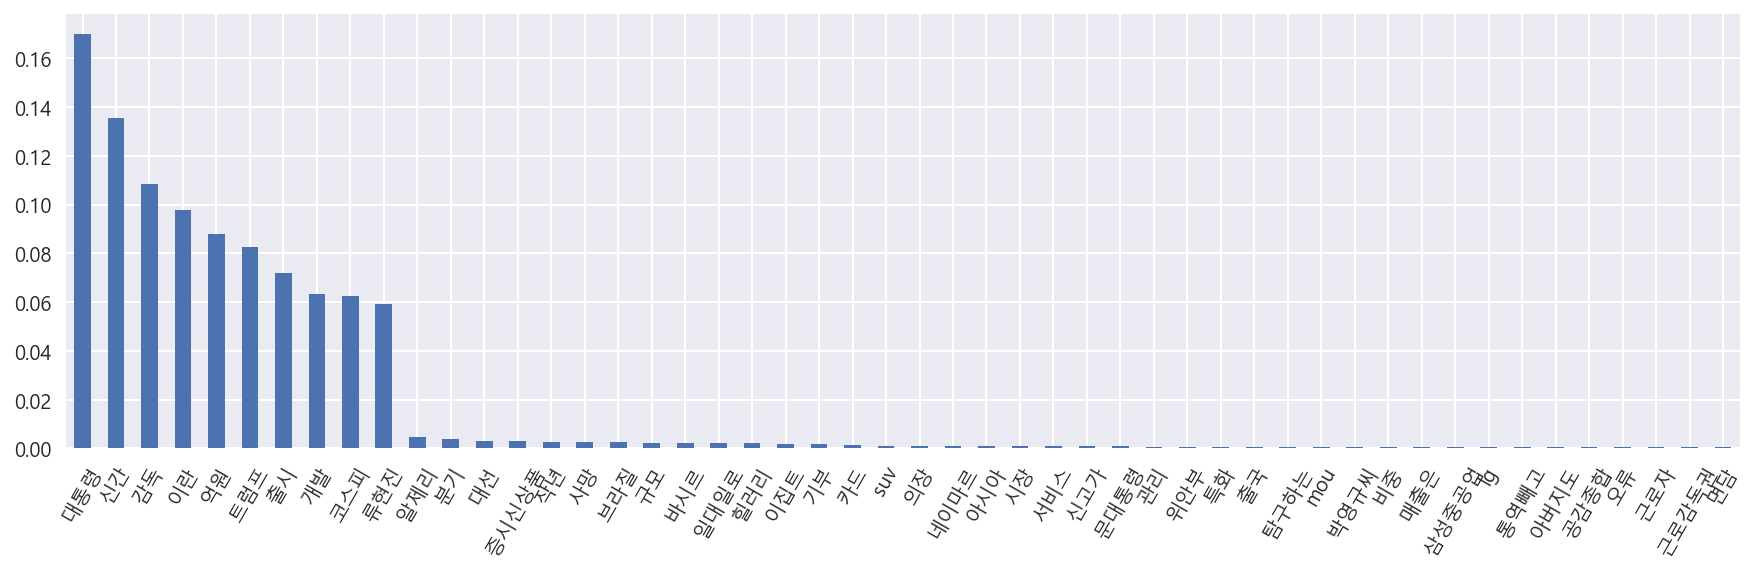

In [50]:
# 피처 중요도를 막대그래프로 시각화 합니다.
fim_large.plot.bar(rot = 60, figsize = (15,4))

### 11.2 예측

In [54]:
# predict로 예측합니다. 
# y_predict
y_predict = model.predict(X_test)
y_predict[:10]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int64)

In [57]:
pd.Series(y_predict).value_counts()

2    7961
6     264
4     227
1     209
0     182
5     177
3     111
dtype: int64

## 12 제출 파일 불러오기
* 답안지에 답을 옮겨 적고 제출하는 과정과 유사합니다.

In [60]:
# sample_submission 파일을 불러옵니다.
# submit
submit = pd.read_csv("data/sample_submission.csv")
submit

,index,topic_idx
0,45654,0
1,45655,0
2,45656,0
3,45657,0
4,45658,0
...,...,...
9126,54780,0
9127,54781,0
9128,54782,0
9129,54783,0


In [62]:
# 예측 값을 답안지에 옮겨 담습니다.
# 실제 시험을 보고 답안지에 답을 옮기는 과정과 유사합니다.
submit['topic_idx']=y_predict
submit.head()

,index,topic_idx
0,45654,2
1,45655,2
2,45656,2
3,45657,2
4,45658,2


## 13 제출을 위해 파일 저장

In [64]:
file_name = "data/submission_dt.csv"
file_name

'data/submission_dt.csv'

In [67]:
# 제출을 위해 파일 저장하기
submit.to_csv(file_name,index=False)

In [68]:
# 잘 저장되었는지 확인하기
pd.read_csv(file_name)

,index,topic_idx
0,45654,2
1,45655,2
2,45656,2
3,45657,2
4,45658,2
...,...,...
9126,54780,2
9127,54781,2
9128,54782,2
9129,54783,2


* dacon에 제출해서 리더보드 확인하기 : https://dacon.io/competitions/official/235747/mysubmission


## 여러 방법을 통해 예측비율을 높여보세요. 
* 아래 항목 외의 기법을 사용해도 됩니다.
 * 전처리 하기
 * 불용어 처리
 * BOW, TF-IDF의 파라메터 변경
 * 분류기의 파라메터 변경
 * 분류기 변경